In [1]:
import os
import pandas as pd
import torch
from IPython.core.display import display
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import torch.optim.lr_scheduler as lr_scheduler
import math


In [ ]:
class MPLayer_in_K(torch.nn.Module):
  def __init__(self,inp_node,out_node,gamma,diff=0):
    super().__init__()
    self.inp_node = inp_node
    self.out_node = out_node
    self.gamma = gamma
    self.diff = diff # differential inputs are given or not
    torch.manual_seed(43)
    self.weight = torch.nn.Parameter(torch.empty(inp_node, out_node), requires_grad=True)
    torch.nn.init.xavier_normal_(self.weight, gain=1.0)
    torch.clamp(self.weight,-3,3)
    self.fn = MPLayer_in_K.SpikeK.apply

  def forward(self, inputp, inputn=None):
      inputp = torch.unsqueeze(inputp,axis=-1)
      self.weight.type_as(inputp)
      if(inputn==None):
        plusIn =F.relu((3+inputp))
        minusIn =F.relu((3-inputp))
      else:
        minusIn = torch.unsqueeze(inputn,axis=-1)
        plusIn = inputp

      plusW = F.relu(self.weight)
      minusW = F.relu(-self.weight)

      zPlus = torch.cat([(plusIn+plusW),(minusIn+minusW)],axis=1)
      zMinus = torch.cat([(plusIn+minusW),(minusIn+plusW)],axis=1)

      zPlus = self.fn(zPlus, self.gamma)
      zMinus = self.fn(zMinus, self.gamma)
      torch.cuda.empty_cache()
      if(self.diff == 0):
        return zPlus - zMinus  ## previous TEMP based codes will not be compatible because of this change
      else:
        return zPlus,zMinus

  @staticmethod
  class SpikeK(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inMat1, gamma):
        ctx.gamma = gamma
        ctx.save_for_backward(inMat1)
        if gamma == 0 or gamma == 1:
            out = torch.kthvalue(inMat1, 1, dim=1).values
            return out
        thr, _ = torch.topk(inMat1, int(gamma), dim=1, largest=False, sorted=False)
        sum_nonzero = thr.sum(dim=1)
        return sum_nonzero / gamma  # average of the smallest gamma values

    @staticmethod
    def backward(ctx, grad_output):
        gamma = ctx.gamma
        inMat1, = ctx.saved_tensors
        grad_input = torch.zeros_like(inMat1)
        thr,indices = torch.topk(inMat1, gamma, dim=1, largest=False, sorted=False)
        grad_vals = (grad_output / gamma).unsqueeze(1).expand_as(indices)
        grad_input.scatter_(dim=1, index=indices, src=grad_vals)
        return grad_input, None

def batch_pearson_corr(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    x_centered = x - x.mean(dim=1, keepdim=True)
    y_centered = y - y.mean(dim=1, keepdim=True)
    numerator = torch.sum(x_centered * y_centered, dim=1)
    denominator = torch.sqrt(torch.sum(x_centered**2, dim=1)) * torch.sqrt(torch.sum(y_centered**2, dim=1))
    return numerator / (denominator + 1e-6)

In [3]:
# Define 3-layers MLP
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Network parameters
input_dim = 28 * 28  # MNIST images (flattened)
hidden_dim = 50
output_dim = 10
lr = 0.1
epochs = 30
device = "cuda:0"
# Initialize weights (manual)
W1 = torch.randn((hidden_dim, input_dim), device=device) * 0.01
W2 = torch.randn((output_dim, hidden_dim), device=device) * 0.01

# Enable gradient tracking
W1.requires_grad_()
W2.requires_grad_()

# Training loop
for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        # Forward pass
        h = F.relu(F.linear(x, W1))
        logits = F.linear(h, W2)

        loss = F.cross_entropy(logits, y)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        with torch.no_grad():
            for W in [W1, W2]:
                W -= lr * W.grad
                W.grad.zero_()

        # Accuracy during training
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch+1}: Train Loss = {total_loss/len(train_loader):.4f}, Accuracy = {acc:.2f}%")

# --- Test Evaluation ---
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
W1.requires_grad = False
W2.requires_grad = False
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h_mlp = F.relu(F.linear(x, W1))
        logits_mlp = F.linear(h_mlp, W2)
        preds_mlp = torch.argmax(logits_mlp, dim=1)

        correct_test += (preds_mlp == y).sum().item()
        total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(f"\nTest Accuracy: {test_acc:.2f}%")
# Save model weights
model_path = "mlp_weights.pth"
torch.save({'W1': W1, 'W2': W2}, model_path)
print(f"Model saved to {model_path}")
# Load model weights
checkpoint = torch.load(model_path, map_location=device)
W1 = checkpoint['W1']
W2 = checkpoint['W2']
W1.requires_grad_()
W2.requires_grad_()


Epoch 1: Train Loss = 0.8416, Accuracy = 78.12%
Epoch 2: Train Loss = 0.3295, Accuracy = 90.64%
Epoch 3: Train Loss = 0.2780, Accuracy = 92.12%
Epoch 4: Train Loss = 0.2390, Accuracy = 93.25%
Epoch 5: Train Loss = 0.2093, Accuracy = 94.04%
Epoch 6: Train Loss = 0.1865, Accuracy = 94.72%
Epoch 7: Train Loss = 0.1690, Accuracy = 95.21%
Epoch 8: Train Loss = 0.1549, Accuracy = 95.56%
Epoch 9: Train Loss = 0.1427, Accuracy = 95.89%
Epoch 10: Train Loss = 0.1325, Accuracy = 96.20%
Epoch 11: Train Loss = 0.1237, Accuracy = 96.47%
Epoch 12: Train Loss = 0.1160, Accuracy = 96.70%
Epoch 13: Train Loss = 0.1098, Accuracy = 96.92%
Epoch 14: Train Loss = 0.1033, Accuracy = 97.02%
Epoch 15: Train Loss = 0.0980, Accuracy = 97.25%
Epoch 16: Train Loss = 0.0936, Accuracy = 97.27%
Epoch 17: Train Loss = 0.0892, Accuracy = 97.45%
Epoch 18: Train Loss = 0.0850, Accuracy = 97.56%
Epoch 19: Train Loss = 0.0817, Accuracy = 97.63%
Epoch 20: Train Loss = 0.0781, Accuracy = 97.70%
Epoch 21: Train Loss = 0.0753

tensor([[ 2.8203e-01,  3.6125e-01, -3.8789e-01,  9.4296e-01, -5.0550e-01,
          6.0517e-02, -1.8779e-01,  4.2692e-01,  1.5205e-02,  2.1385e-01,
         -5.0184e-01, -4.3709e-01,  2.5763e-01,  2.2154e-01, -2.0302e-01,
          5.3678e-01, -1.2809e-02, -1.1616e-01,  1.2219e-01,  1.7147e-01,
         -2.3093e-01, -3.6727e-01, -1.8178e-01,  5.5467e-01, -4.2554e-01,
         -2.6842e-03, -2.3452e-02, -1.2601e+00, -2.7110e-01,  2.7391e-01,
         -6.3816e-01, -1.5005e-01,  2.6720e-03,  2.3857e-02, -5.7324e-01,
          2.6346e-01, -5.2830e-01, -7.5520e-01,  7.6852e-01, -5.6061e-01,
         -6.4400e-02,  1.1887e-03, -1.6646e-01, -5.0691e-01,  5.5708e-01,
         -7.1239e-01, -2.3098e-01,  1.7816e-01,  2.8476e-01, -6.9343e-01],
        [-3.3716e-01,  4.4966e-03, -4.2866e-01, -6.7642e-01,  9.3953e-01,
         -3.2043e-01,  2.4939e-01, -5.7298e-01,  1.6811e-01, -7.4632e-01,
          7.2720e-01,  1.9052e-01, -3.0019e-01,  1.4590e-02,  1.1388e-01,
         -2.9032e-01,  1.5528e+00, -6

In [4]:
model_path = "mlp_weights.pth"

checkpoint = torch.load(model_path, map_location=device)
W1 = checkpoint['W1']
W2 = checkpoint['W2']
W1.requires_grad_()
W2.requires_grad_()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h_mlp = F.relu(F.linear(x, W1))
        logits_mlp = F.linear(h_mlp, W2)
        preds_mlp = torch.argmax(logits_mlp, dim=1)

        correct_test += (preds_mlp == y).sum().item()
        total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(f"\nTest Accuracy: {test_acc:.2f}%")


Test Accuracy: 97.22%


TOPK inference
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
[0.9017365  0.9184125  0.9316989  0.9424892  0.9514462  0.95888495
 0.96499276 0.97001296 0.97414666 0.977538   0.98025614 0.98237467
 0.9839864  0.9851743  0.985999   0.98653907 0.9868444  0.98696226
 0.9869281  0.98679745]


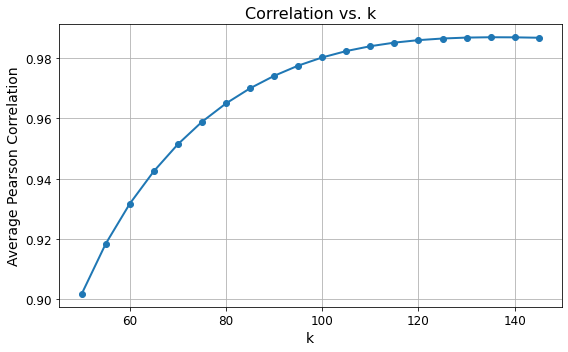

In [5]:
print("TOPK inference")
corr = []
test_loader1 = DataLoader(test_dataset, batch_size=10000, shuffle=False)
kend = 150
kstart = 50
kstep = 5
for k in range(kstart,kend,kstep):
    print(k)
    K = [k, 16] #90
    layer1 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
    layer1.weight.data = W1.t().clone()
    layer2 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
    layer2.weight.data = W2.t().clone()
    scaling = 30
    with torch.no_grad():
        for images, labels in test_loader1:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)
            h = F.relu(-layer1(x)*scaling)
            logits = -layer2(h)*scaling
            h_mlp = F.relu(F.linear(x, W1))
            logits_mlp = F.linear(h_mlp, W2)
            
    correlations = batch_pearson_corr(h_mlp, h)
    c = torch.mean(correlations)
    corr.append(c)
corr_tensor = torch.stack(corr).cpu().numpy()
print(corr_tensor)
k_values = list(range(kstart, kend, kstep))
plt.figure(figsize=(8, 5))
plt.plot(k_values, corr_tensor, marker='o', linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('Average Pearson Correlation', fontsize=14)
plt.title('Correlation vs. k', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

TOPK inference
1
6
11
16
21
26
31
36
41
46
[0.51656127 0.7199733  0.76146543 0.761258   0.76063555 0.7604128
 0.760037   0.75498056 0.7434194  0.7398443 ]


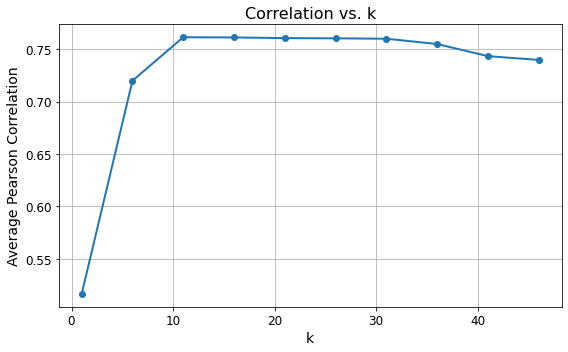

In [6]:
print("TOPK inference")
corr = []
test_loader1 = DataLoader(test_dataset, batch_size=10000, shuffle=False)
kend = 50
kstart = 1
kstep = 5
for k in range(kstart,kend,kstep):
    print(k)
    K = [140, k] #90
    layer1 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
    layer1.weight.data = W1.t().clone()
    layer2 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
    layer2.weight.data = W2.t().clone()
    scaling = 1
    with torch.no_grad():
        for images, labels in test_loader1:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)
            h = F.relu(-layer1(x)*scaling)
            logits = -layer2(h)*scaling
            h_mlp = F.relu(F.linear(x, W1))
            logits_mlp = F.linear(h_mlp, W2)        
    correlations = batch_pearson_corr(logits_mlp, logits)
    c = torch.mean(correlations)
    corr.append(c)
corr_tensor = torch.stack(corr).cpu().numpy()
print(corr_tensor)
k_values = list(range(kstart, kend, kstep))
plt.figure(figsize=(8, 5))
plt.plot(k_values, corr_tensor, marker='o', linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('Average Pearson Correlation', fontsize=14)
plt.title('Correlation vs. k', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Train Accuracy: 88.93%


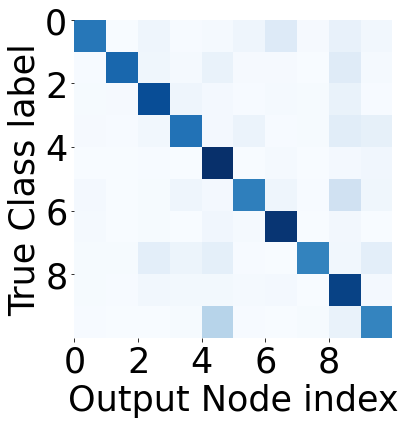

In [7]:
K = [140,16] #90
layer1 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer1.weight.data = W1.t().clone()
layer2 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer2.weight.data = W2.t().clone()
correct_test = 0
total_test = 0
scaling = 30
with torch.no_grad():
    for images, labels in train_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h = F.relu(-layer1(x)*scaling)
        logits = -layer2(h)*scaling
        preds = torch.argmax(logits, dim=1)

        correct_test += (preds == y).sum().item()
        total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(f"\nTrain Accuracy: {test_acc:.2f}%")


#confusion matrix
test_loader2 = DataLoader(test_dataset, batch_size=10000, shuffle=False)
# Concatenate entire test set for easy batch evaluation
images, labels = next(iter(test_loader2))
X_tensor = images.view(-1, 28 * 28)
Y_tensor = labels
output_dim = 10  # For MNIST 0-9
# Compute output activations
scaling = 30
with torch.no_grad():
    h = scaling*F.relu(-layer1(X_tensor.to(device)))
    logits = -scaling*layer2(h)
    probs = torch.softmax(logits, dim=1)  # Cross-entropy used => softmax output

# Initialize class-wise average activation matrix
avg_output_activation = torch.zeros((output_dim, output_dim))

# Compute per-class output activation average
for cls in range(output_dim):
    idx = (Y_tensor == cls)
    class_probs = probs[idx]  # Shape: (num_samples_in_class, output_dim)
    avg_output_activation[cls] = class_probs.mean(dim=0)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    avg_output_activation.numpy(),
    cmap="Blues",
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    square=True,
)
# Control tick label font sizes
fsize = 35
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
ax.set_xlabel("Output Node index", fontsize=fsize)
ax.set_ylabel("True Class label", fontsize=fsize)
# ax.set_title("Average Output Node Activation per MNIST Class", fontsize=fsize)

tick_indices = list(range(0, output_dim, 2))  # Every 2nd label: 0, 2, 4, 6, 8

# Set custom tick locations and labels
ax.set_xticks(tick_indices)
ax.set_xticklabels([str(i) for i in tick_indices], fontsize=fsize)
ax.set_yticks(tick_indices)
ax.set_yticklabels([str(i) for i in tick_indices], fontsize=fsize)
# Control colorbar tick label font size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=fsize)  # Set font size for colorbar ticks

plt.tight_layout()
plt.show()


Train Accuracy: 88.93%


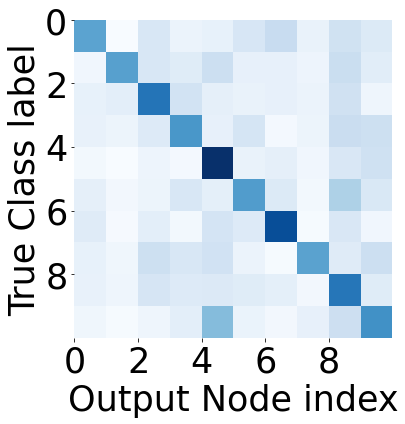

In [8]:
K = [140,16] #90
layer1 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer1.weight.data = W1.t().clone()
layer2 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer2.weight.data = W2.t().clone()
correct_test = 0
total_test = 0
scaling = 30
scaling2 = 10
with torch.no_grad():
    for images, labels in train_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h = F.relu(-layer1(x)*scaling)
        logits = -layer2(h)*scaling2
        preds = torch.argmax(logits, dim=1)

        correct_test += (preds == y).sum().item()
        total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(f"\nTrain Accuracy: {test_acc:.2f}%")


#confusion matrix
test_loader2 = DataLoader(test_dataset, batch_size=10000, shuffle=False)
# Concatenate entire test set for easy batch evaluation
images, labels = next(iter(test_loader2))
X_tensor = images.view(-1, 28 * 28)
Y_tensor = labels
output_dim = 10  # For MNIST 0-9
# Compute output activations
with torch.no_grad():
    h = scaling*F.relu(-layer1(X_tensor.to(device)))
    logits = -scaling2*layer2(h)
    probs = torch.softmax(logits, dim=1)  # Cross-entropy used => softmax output

# Initialize class-wise average activation matrix
avg_output_activation = torch.zeros((output_dim, output_dim))

# Compute per-class output activation average
for cls in range(output_dim):
    idx = (Y_tensor == cls)
    class_probs = probs[idx]  # Shape: (num_samples_in_class, output_dim)
    avg_output_activation[cls] = class_probs.mean(dim=0)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    avg_output_activation.numpy(),
    cmap="Blues",
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    square=True,
)
# Control tick label font sizes
fsize = 35
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
ax.set_xlabel("Output Node index", fontsize=fsize)
ax.set_ylabel("True Class label", fontsize=fsize)
# ax.set_title("Average Output Node Activation per MNIST Class", fontsize=fsize)

tick_indices = list(range(0, output_dim, 2))  # Every 2nd label: 0, 2, 4, 6, 8

# Set custom tick locations and labels
ax.set_xticks(tick_indices)
ax.set_xticklabels([str(i) for i in tick_indices], fontsize=fsize)
ax.set_yticks(tick_indices)
ax.set_yticklabels([str(i) for i in tick_indices], fontsize=fsize)
# Control colorbar tick label font size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=fsize)  # Set font size for colorbar ticks

plt.tight_layout()
plt.show()


Train Accuracy: 88.93%


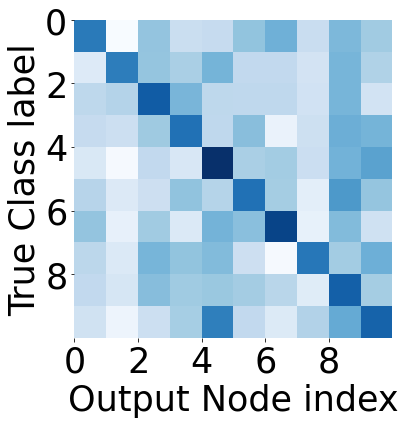

In [9]:
K = [140,16] #90
layer1 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer1.weight.data = W1.t().clone()
layer2 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer2.weight.data = W2.t().clone()
correct_test = 0
total_test = 0
scaling = 30
scaling2 = 1
with torch.no_grad():
    for images, labels in train_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h = F.relu(-layer1(x)*scaling)
        logits = -layer2(h)*scaling2
        preds = torch.argmax(logits, dim=1)

        correct_test += (preds == y).sum().item()
        total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(f"\nTrain Accuracy: {test_acc:.2f}%")


#confusion matrix
test_loader2 = DataLoader(test_dataset, batch_size=10000, shuffle=False)
# Concatenate entire test set for easy batch evaluation
images, labels = next(iter(test_loader2))
X_tensor = images.view(-1, 28 * 28)
Y_tensor = labels
output_dim = 10  # For MNIST 0-9
# Compute output activations
with torch.no_grad():
    h = scaling*F.relu(-layer1(X_tensor.to(device)))
    logits = -scaling2*layer2(h)
    probs = torch.softmax(logits, dim=1)  # Cross-entropy used => softmax output

# Initialize class-wise average activation matrix
avg_output_activation = torch.zeros((output_dim, output_dim))

# Compute per-class output activation average
for cls in range(output_dim):
    idx = (Y_tensor == cls)
    class_probs = probs[idx]  # Shape: (num_samples_in_class, output_dim)
    avg_output_activation[cls] = class_probs.mean(dim=0)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    avg_output_activation.numpy(),
    cmap="Blues",
    xticklabels=False,
    yticklabels=False,
    cbar=False,
    square=True,
)
# Control tick label font sizes
fsize = 35
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
ax.set_xlabel("Output Node index", fontsize=fsize)
ax.set_ylabel("True Class label", fontsize=fsize)
# ax.set_title("Average Output Node Activation per MNIST Class", fontsize=fsize)

tick_indices = list(range(0, output_dim, 2))  # Every 2nd label: 0, 2, 4, 6, 8

# Set custom tick locations and labels
ax.set_xticks(tick_indices)
ax.set_xticklabels([str(i) for i in tick_indices], fontsize=fsize)
ax.set_yticks(tick_indices)
ax.set_yticklabels([str(i) for i in tick_indices], fontsize=fsize)
# Control colorbar tick label font size
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=fsize)  # Set font size for colorbar ticks

plt.tight_layout()
plt.show()

In [37]:
#gradient descent on topk networks with scaling
# Define 3-layers MLP
K = [140,16] #90
layer11 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer11.weight.data = W1.t().clone()
layer22 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer22.weight.data = W2.t().clone()
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Network parameters
input_dim = 28 * 28  # MNIST images (flattened)
hidden_dim = 50
output_dim = 10
lr = 0.1
epochs = 20

import matplotlib.pyplot as plt
train_acc_list = []
test_acc_list = []
loss_list = []
optimizer = torch.optim.SGD(list(layer11.parameters()) + list(layer22.parameters()), lr=lr)

# Training loop
scaling=30
for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h = F.relu(-scaling * layer11(x))
        logits = -scaling * layer22(h)

        loss = F.cross_entropy(logits, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_acc = correct / total * 100
    train_acc_list.append(train_acc)
    loss_list.append(total_loss / len(train_loader))

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)

            h = F.relu(-scaling * layer11(x))
            logits = -scaling * layer22(h)
            preds = torch.argmax(logits, dim=1)

            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

    test_acc = correct_test / total_test * 100
    test_acc_list.append(test_acc)
    print(f"Epoch {epoch+1}: Train Loss = {loss_list[-1]:.4f}, Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%")
    # Plot Accuracy

# Create a dictionary of training metrics
metrics = {
    'Epoch': list(range(1, len(loss_list) + 1)),
    'Train_Loss': loss_list,
    'Train_Accuracy': train_acc_list,
    'Test_Accuracy': test_acc_list
}
# Convert to DataFrame
df = pd.DataFrame(metrics)
# Save to CSV
df.to_csv("training_metrics_k_30.csv", index=False)
# Save model weights
model_path = "pik30_weights.pth"
# torch.save({'W1': layer11.weight.data, 'W2': layer22.weight.data}, model_path)
# print(f"Model saved to {model_path}")
# Load model weights
checkpoint = torch.load(model_path, map_location=device)
layer11.weight.data = checkpoint['W1']
layer22.weight.data = checkpoint['W2']
layer11.weight.data.requires_grad_()
layer22.weight.data.requires_grad_()


Epoch 1: Train Loss = 0.1461, Train Acc = 96.44%, Test Acc = 96.50%
Epoch 2: Train Loss = 0.1138, Train Acc = 96.97%, Test Acc = 96.68%
Epoch 3: Train Loss = 0.1037, Train Acc = 97.21%, Test Acc = 96.89%
Epoch 4: Train Loss = 0.0973, Train Acc = 97.36%, Test Acc = 96.78%
Epoch 5: Train Loss = 0.0922, Train Acc = 97.53%, Test Acc = 96.86%
Epoch 6: Train Loss = 0.0883, Train Acc = 97.65%, Test Acc = 97.00%
Epoch 7: Train Loss = 0.0848, Train Acc = 97.72%, Test Acc = 97.07%
Epoch 8: Train Loss = 0.0816, Train Acc = 97.82%, Test Acc = 97.02%
Epoch 9: Train Loss = 0.0788, Train Acc = 97.92%, Test Acc = 97.10%
Epoch 10: Train Loss = 0.0765, Train Acc = 98.03%, Test Acc = 97.15%
Epoch 11: Train Loss = 0.0741, Train Acc = 98.08%, Test Acc = 97.18%
Epoch 12: Train Loss = 0.0720, Train Acc = 98.13%, Test Acc = 97.26%
Epoch 13: Train Loss = 0.0702, Train Acc = 98.18%, Test Acc = 97.09%
Epoch 14: Train Loss = 0.0685, Train Acc = 98.24%, Test Acc = 97.22%
Epoch 15: Train Loss = 0.0667, Train Acc = 

tensor([[ 0.3224, -0.4113, -0.3579, -0.7016, -1.3437,  1.4650, -0.1584,  1.1195,
          0.0989,  0.3646],
        [ 0.5499,  0.3719, -0.1471, -0.5229,  0.2308,  0.0386,  0.5896,  0.7934,
         -1.0501, -0.2817],
        [-0.5424, -0.4134, -0.4374, -0.4204,  0.7241, -0.6354, -0.3575,  0.6319,
          0.3359,  1.0315],
        [ 1.3591, -0.7384,  1.3270,  0.3874, -1.0261,  0.8409,  0.3287, -0.7854,
          0.4450, -0.6905],
        [-0.5446,  1.1115,  0.5497,  0.9966, -0.5506, -0.7320,  0.2338,  1.1700,
          0.1988, -1.3663],
        [ 0.1991, -0.3746, -0.4807, -0.6347,  0.9175,  0.7472,  0.2386,  0.3188,
          0.4726, -1.1668],
        [-0.3786,  0.5051,  0.6161,  0.2386,  0.2526, -0.1850, -0.0846,  0.4841,
         -0.5461, -0.6242],
        [ 0.7048, -0.8086,  0.8168,  0.2363,  0.0211,  0.6813,  1.0279, -0.9080,
          0.0669, -1.0609],
        [ 0.1637,  0.4453, -0.4337,  0.7915,  0.5712, -0.6480,  0.4957,  0.2693,
         -0.6019, -0.5837],
        [ 0.5283, -

In [38]:
model_path = "pik30_weights.pth"
torch.save({'W1': layer11.weight.data, 'W2': layer22.weight.data}, model_path)
print(f"Model saved to {model_path}")
# Load model weights
checkpoint = torch.load(model_path, map_location=device)
layer11.weight.data = checkpoint['W1']
layer22.weight.data = checkpoint['W2']
layer11.weight.data.requires_grad_()
layer22.weight.data.requires_grad_()

Model saved to pik30_weights.pth


tensor([[ 0.3224, -0.4113, -0.3579, -0.7016, -1.3437,  1.4650, -0.1584,  1.1195,
          0.0989,  0.3646],
        [ 0.5499,  0.3719, -0.1471, -0.5229,  0.2308,  0.0386,  0.5896,  0.7934,
         -1.0501, -0.2817],
        [-0.5424, -0.4134, -0.4374, -0.4204,  0.7241, -0.6354, -0.3575,  0.6319,
          0.3359,  1.0315],
        [ 1.3591, -0.7384,  1.3270,  0.3874, -1.0261,  0.8409,  0.3287, -0.7854,
          0.4450, -0.6905],
        [-0.5446,  1.1115,  0.5497,  0.9966, -0.5506, -0.7320,  0.2338,  1.1700,
          0.1988, -1.3663],
        [ 0.1991, -0.3746, -0.4807, -0.6347,  0.9175,  0.7472,  0.2386,  0.3188,
          0.4726, -1.1668],
        [-0.3786,  0.5051,  0.6161,  0.2386,  0.2526, -0.1850, -0.0846,  0.4841,
         -0.5461, -0.6242],
        [ 0.7048, -0.8086,  0.8168,  0.2363,  0.0211,  0.6813,  1.0279, -0.9080,
          0.0669, -1.0609],
        [ 0.1637,  0.4453, -0.4337,  0.7915,  0.5712, -0.6480,  0.4957,  0.2693,
         -0.6019, -0.5837],
        [ 0.5283, -

In [39]:
#gradient descent on topk networks with scaling
# Define 3-layers MLP
K = [140,16] #90
layer111 = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer111.weight.data = W1.t().clone()
layer222 = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer222.weight.data = W2.t().clone()
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Network parameters
input_dim = 28 * 28  # MNIST images (flattened)
hidden_dim = 50
output_dim = 10
lr = 0.1
epochs = 20

import matplotlib.pyplot as plt
train_acc_list = []
test_acc_list = []
loss_list = []
optimizer = torch.optim.SGD(list(layer111.parameters()) + list(layer222.parameters()), lr=lr)

# Training loop
scaling=10
for epoch in range(epochs):
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h = F.relu(-scaling * layer111(x))
        logits = -scaling * layer222(h)

        loss = F.cross_entropy(logits, y)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_acc = correct / total * 100
    train_acc_list.append(train_acc)
    loss_list.append(total_loss / len(train_loader))

    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)

            h = F.relu(-scaling * layer111(x))
            logits = -scaling * layer222(h)
            preds = torch.argmax(logits, dim=1)

            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

    test_acc = correct_test / total_test * 100
    test_acc_list.append(test_acc)
    print(f"Epoch {epoch+1}: Train Loss = {loss_list[-1]:.4f}, Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%")
    # Plot Accuracy

# Create a dictionary of training metrics
metrics = {
    'Epoch': list(range(1, len(loss_list) + 1)),
    'Train_Loss': loss_list,
    'Train_Accuracy': train_acc_list,
    'Test_Accuracy': test_acc_list
}
# Convert to DataFrame
df = pd.DataFrame(metrics)
# Save to CSV
df.to_csv("training_metrics_k_10.csv", index=False)
# Save model weights
model_path = "pik10_weights.pth"
torch.save({'W1': layer11.weight.data, 'W2': layer22.weight.data}, model_path)
print(f"Model saved to {model_path}")
# Load model weights
checkpoint = torch.load(model_path, map_location=device)
layer111.weight.data = checkpoint['W1']
layer222.weight.data = checkpoint['W2']
layer111.weight.data.requires_grad_()
layer222.weight.data.requires_grad_()

Epoch 1: Train Loss = 0.9932, Train Acc = 91.68%, Test Acc = 91.71%
Epoch 2: Train Loss = 0.6438, Train Acc = 91.43%, Test Acc = 91.86%
Epoch 3: Train Loss = 0.5291, Train Acc = 91.55%, Test Acc = 91.90%
Epoch 4: Train Loss = 0.4682, Train Acc = 91.73%, Test Acc = 92.08%
Epoch 5: Train Loss = 0.4293, Train Acc = 91.88%, Test Acc = 92.18%
Epoch 6: Train Loss = 0.4016, Train Acc = 92.06%, Test Acc = 92.36%
Epoch 7: Train Loss = 0.3803, Train Acc = 92.23%, Test Acc = 92.56%
Epoch 8: Train Loss = 0.3634, Train Acc = 92.37%, Test Acc = 92.69%
Epoch 9: Train Loss = 0.3493, Train Acc = 92.53%, Test Acc = 92.79%
Epoch 10: Train Loss = 0.3375, Train Acc = 92.61%, Test Acc = 92.93%
Epoch 11: Train Loss = 0.3273, Train Acc = 92.74%, Test Acc = 92.96%
Epoch 12: Train Loss = 0.3185, Train Acc = 92.82%, Test Acc = 93.07%
Epoch 13: Train Loss = 0.3107, Train Acc = 92.94%, Test Acc = 93.15%
Epoch 14: Train Loss = 0.3037, Train Acc = 93.03%, Test Acc = 93.26%
Epoch 15: Train Loss = 0.2974, Train Acc = 

tensor([[ 0.3224, -0.4113, -0.3579, -0.7016, -1.3437,  1.4650, -0.1584,  1.1195,
          0.0989,  0.3646],
        [ 0.5499,  0.3719, -0.1471, -0.5229,  0.2308,  0.0386,  0.5896,  0.7934,
         -1.0501, -0.2817],
        [-0.5424, -0.4134, -0.4374, -0.4204,  0.7241, -0.6354, -0.3575,  0.6319,
          0.3359,  1.0315],
        [ 1.3591, -0.7384,  1.3270,  0.3874, -1.0261,  0.8409,  0.3287, -0.7854,
          0.4450, -0.6905],
        [-0.5446,  1.1115,  0.5497,  0.9966, -0.5506, -0.7320,  0.2338,  1.1700,
          0.1988, -1.3663],
        [ 0.1991, -0.3746, -0.4807, -0.6347,  0.9175,  0.7472,  0.2386,  0.3188,
          0.4726, -1.1668],
        [-0.3786,  0.5051,  0.6161,  0.2386,  0.2526, -0.1850, -0.0846,  0.4841,
         -0.5461, -0.6242],
        [ 0.7048, -0.8086,  0.8168,  0.2363,  0.0211,  0.6813,  1.0279, -0.9080,
          0.0669, -1.0609],
        [ 0.1637,  0.4453, -0.4337,  0.7915,  0.5712, -0.6480,  0.4957,  0.2693,
         -0.6019, -0.5837],
        [ 0.5283, -

In [40]:
#storing wts for scatter plot
import numpy as np
import matplotlib.pyplot as plt
# Example matrices (Replace these with your data)
fsize = 15
matrix1 = W1.clone().detach().cpu().numpy()
matrix2 = layer11.weight.data.t().clone().cpu().numpy()
m, n = W1.size()
# Save the data to CSV
np.savetxt('matrix1.csv', matrix1[0], delimiter=',')  # Save first row of matrix1
np.savetxt('matrix2.csv', matrix2[0], delimiter=',')  # Save first row of matrix2

In [41]:
# tsne for topk1 with initialization after training
hidden_activations_k1 = []
output_k1 = []
y_out_k1 = []
count = 0
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
scaling = 30
correct_test = 0
total_test = 0
with torch.no_grad():
        for images, labels in test_loader:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)

            h = F.relu(-scaling * layer11(x))
            logits = -scaling * layer22(h)
            preds = torch.argmax(logits, dim=1)

            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(test_acc)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

for image, label in test_loader:
        image = image.to(device)
        image = image.flatten(start_dim=1)
        h = F.relu(-scaling*layer11(image))
        output = -scaling*layer22(h)
        hidden_activations_k1.append((h).cpu().detach().numpy())
        output_k1.append((output).cpu().detach().numpy())
        y_out_k1.append(label.cpu().detach().numpy())
        count += 1
        if count == 4000:
            break

# Apply t-SNE
from sklearn.manifold import TSNE
tsne_k1 = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
hidden_activations_np_k1 = np.array(hidden_activations_k1) # Convert to NumPy array
output_np_k1 = np.array(output_k1) # Convert to NumPy array
y_np_k1 = np.array(y_out_k1) # Convert to NumPy array
hidden_activations_np_k1 = hidden_activations_np_k1.reshape(hidden_activations_np_k1.shape[0], -1)  # Reshape to 2D
output_np_k1 = output_np_k1.reshape(output_np_k1.shape[0], -1)  # Reshape to 2D
X_tsne_k1 = tsne_k1.fit_transform(hidden_activations_np_k1)
X_tsne_out_k1 = tsne_k1.fit_transform(output_np_k1)
# Save t-SNE results to CSV
np.savetxt("X_tsne_k1.csv", X_tsne_k1, delimiter=",")
np.savetxt("X_tsne_out_k1.csv", X_tsne_out_k1, delimiter=",")
np.savetxt("y_out_k1.csv", y_np_k1, delimiter=",")


97.34


In [42]:
# tsne for topk1 with initialization
hidden_activations_k1 = []
output_k1 = []
y_out_k1 = []
count = 0
K = [140,16]
layer1_init = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer1_init.weight.data = W1.t().clone()
layer2_init = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer2_init.weight.data = W2.t().clone()
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
scaling = 30
correct_test = 0
total_test = 0
with torch.no_grad():
        for images, labels in test_loader:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)

            h = F.relu(-scaling * layer1_init(x))
            logits = -scaling * layer2_init(h)
            preds = torch.argmax(logits, dim=1)

            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(test_acc)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

for image, label in test_loader:
        image = image.to(device)
        image = image.flatten(start_dim=1)
        h = F.relu(-scaling*layer1_init(image))
        output = -scaling*layer2_init(h)
        hidden_activations_k1.append((h).cpu().detach().numpy())
        output_k1.append((output).cpu().detach().numpy())
        y_out_k1.append(label.cpu().detach().numpy())
        count += 1
        # if count == 4000:
        #     break

# Apply t-SNE
from sklearn.manifold import TSNE
tsne_k1 = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
hidden_activations_np_k1 = np.array(hidden_activations_k1) # Convert to NumPy array
output_np_k1 = np.array(output_k1) # Convert to NumPy array
y_np_k1 = np.array(y_out_k1) # Convert to NumPy array
hidden_activations_np_k1 = hidden_activations_np_k1.reshape(hidden_activations_np_k1.shape[0], -1)  # Reshape to 2D
output_np_k1 = output_np_k1.reshape(output_np_k1.shape[0], -1)  # Reshape to 2D
X_tsne_k1 = tsne_k1.fit_transform(hidden_activations_np_k1)
X_tsne_out_k1 = tsne_k1.fit_transform(output_np_k1)
# Save t-SNE results to CSV
np.savetxt("X_tsne_k.csv", X_tsne_k1, delimiter=",")
np.savetxt("X_tsne_out_k.csv", X_tsne_out_k1, delimiter=",")
np.savetxt("y_out_k.csv", y_np_k1, delimiter=",")


88.67


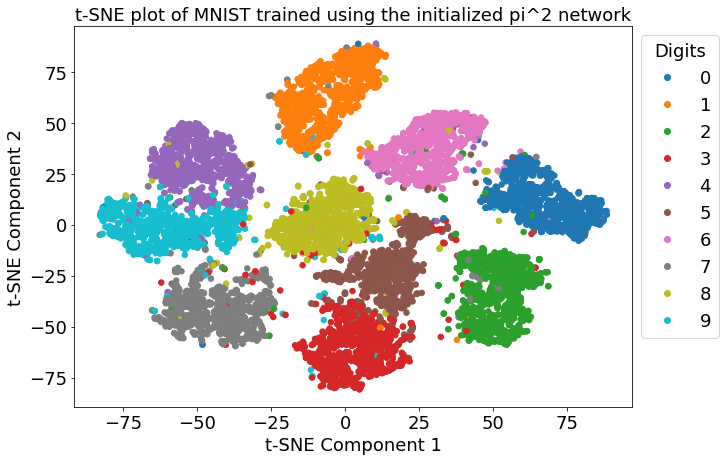

In [43]:
# Plot the result
fsize=18
plt.figure(figsize=(10, 7))
# sns.set(style="whitegrid")

# Scatter plot with improved aesthetics
scatter = plt.scatter(
    X_tsne_k1[:, 0], X_tsne_k1[:, 1],
    c=y_np_k1.astype(int), s=30, cmap='tab10',
)



# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_np.astype(int), cmap='tab10', s=1)
# Move legend outside the plot
plt.legend(
    *scatter.legend_elements(),
    title="Digits",
    fontsize=fsize,  # Font size of legend labels
    title_fontsize=fsize,  # Font size of legend title
    loc="upper left",
    bbox_to_anchor=(1, 1),
    prop={'size': fsize}  # Ensures larger font size
)

plt.title('t-SNE plot of MNIST trained using the initialized pi^2 network',fontsize=fsize)
plt.grid(False)

# Title and labels
# **Increase font size of tick labels**
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("t-SNE Visualization of Hidden Layer Activations", fontsize=14, fontweight="bold")
plt.xlabel("t-SNE Component 1", fontsize=fsize)
plt.ylabel("t-SNE Component 2", fontsize=fsize)

# Remove top and right spines for cleaner look
# sns.despine()
plt.show()



In [44]:
# tsne for MLP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
hidden_activations_mlp = []
output_mlp = []
y_out_mlp = []
count = 0
# device = "cuda:3"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
correct_test = 0
total_test = 0
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        x = images.view(-1, input_dim).to(device)
        y = labels.to(device)

        h_mlp = F.relu(F.linear(x, W1))
        logits_mlp = F.linear(h_mlp, W2)
        preds_mlp = torch.argmax(logits_mlp, dim=1)

        correct_test += (preds_mlp == y).sum().item()
        total_test += y.size(0)

test_acc = correct_test / total_test * 100
print(test_acc)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

for image, label in test_loader:
        image = image.to(device)
        image = image.flatten(start_dim=1)
        h = F.relu(F.linear(image, W1))
        output = F.linear(h, W2)
        hidden_activations_mlp.append((h).cpu().detach().numpy())
        output_mlp.append((output).cpu().detach().numpy())
        y_out_mlp.append(label.cpu().detach().numpy())
        count += 1
        # if count == 4000:
        #     break

# Apply t-SNE
from sklearn.manifold import TSNE
tsne_mlp = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
hidden_activations_np_mlp = np.array(hidden_activations_mlp) # Convert to NumPy array
output_np_mlp = np.array(output_mlp) # Convert to NumPy array
y_np_mlp = np.array(y_out_mlp) # Convert to NumPy array
hidden_activations_np_mlp = hidden_activations_np_mlp.reshape(hidden_activations_np_mlp.shape[0], -1)  # Reshape to 2D
output_np_mlp = output_np_mlp.reshape(output_np_mlp.shape[0], -1)  # Reshape to 2D
X_tsne_mlp = tsne_mlp.fit_transform(hidden_activations_np_mlp)
X_tsne_out_mlp = tsne_mlp.fit_transform(output_np_mlp)
# Save t-SNE results to CSV
np.savetxt("X_tsne_mlp.csv", X_tsne_mlp, delimiter=",")
np.savetxt("X_tsne_out_mlp.csv", X_tsne_out_mlp, delimiter=",")
np.savetxt("y_out_mlp.csv", y_np_mlp, delimiter=",")


97.22


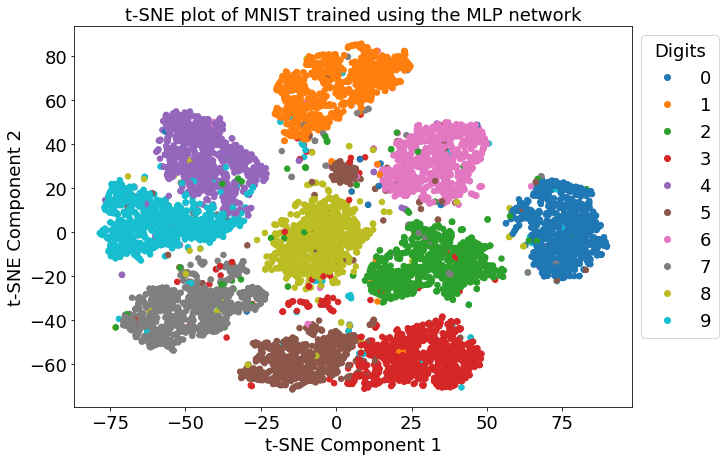

In [45]:
# Plot the result
fsize=18
plt.figure(figsize=(10, 7))
# sns.set(style="whitegrid")

# Scatter plot with improved aesthetics
scatter = plt.scatter(
    X_tsne_mlp[:, 0], X_tsne_mlp[:, 1],
    c=y_np_mlp.astype(int), s=30, cmap='tab10',
)



# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_np.astype(int), cmap='tab10', s=1)
# Move legend outside the plot
plt.legend(
    *scatter.legend_elements(),
    title="Digits",
    fontsize=fsize,  # Font size of legend labels
    title_fontsize=fsize,  # Font size of legend title
    loc="upper left",
    bbox_to_anchor=(1, 1),
    prop={'size': fsize}  # Ensures larger font size
)

plt.title('t-SNE plot of MNIST trained using the MLP network',fontsize=fsize)
plt.grid(False)

# Title and labels
# **Increase font size of tick labels**
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
# plt.title("t-SNE Visualization of Hidden Layer Activations", fontsize=14, fontweight="bold")
plt.xlabel("t-SNE Component 1", fontsize=fsize)
plt.ylabel("t-SNE Component 2", fontsize=fsize)

# Remove top and right spines for cleaner look
# sns.despine()
plt.show()



In [46]:
import torch

# Assuming X_tsne_mlp and X_tsne_k1 are numpy arrays of shape [n_samples, 2]
X_mlp = torch.tensor(X_tsne_mlp, dtype=torch.float32)
X_k1 = torch.tensor(X_tsne_k1, dtype=torch.float32)

# Option 1: compute correlation for each dimension independently
corrs = batch_pearson_corr(X_mlp.T, X_k1.T)

print(f"Pearson correlation (dim 0): {corrs[0].item():.4f}")
print(f"Pearson correlation (dim 1): {corrs[1].item():.4f}")


Pearson correlation (dim 0): 0.9213
Pearson correlation (dim 1): 0.9122


In [47]:
K = [140,16] #90
layer1k = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer1k.weight.data =layer11.weight.data.clone()
layer2k = MPLayer_in_K(inp_node=hidden_dim, out_node=hidden_dim, gamma=K[1], diff=0)
layer2k.weight.data = layer22.weight.data.clone()/30
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
scaling = 1
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)

            h = F.relu(-scaling*layer1k(x))
            logits = -layer2k(h)
            preds = torch.argmax(logits, dim=1)

            correct_test += (preds == y).sum().item()
            total_test += y.size(0)

    test_acc = correct_test / total_test * 100
    test_acc_list.append(test_acc)
    print(f"Test Acc = {test_acc:.2f}%")

Test Acc = 97.34%


In [48]:
#quantize to 3 bits and evaluate
W1k = layer1k.weight.data.clone()
W2k = layer2k.weight.data.clone()
# print(W1k)
# print(W2k)
n = 4
q = 2**(n-1) - 1 # 8 bit quantiazation
print(q)
k1 = (torch.max(torch.abs(W1k)))
k2 = (torch.max(torch.abs(W2k)))
# max_val = torch.max(k1,k2)
scaling_factor1 = q / k1
scaling_factor2 = q / k2
print(scaling_factor1)
print(scaling_factor2)
int_k1 = torch.round(W1k * scaling_factor1)
int_k2 = torch.round(W2k * scaling_factor2)
quant_k1 = int_k1 / scaling_factor1
quant_k2 = int_k2 / scaling_factor2
# print(int_k1)
# print(int_k2)

# Define model layers using nn.Linear
K = [140,16]
layer11k = MPLayer_in_K(inp_node=input_dim, out_node=hidden_dim, gamma=K[0], diff=0)
layer22k = MPLayer_in_K(inp_node=hidden_dim, out_node=output_dim, gamma=K[1], diff=0)
layer11k.weight.data = quant_k1.clone()
layer22k.weight.data = quant_k2.clone()
# layer11k.weight.data = W1k.clone()
# layer22k.weight.data = W2k.clone()
# Optimizer

# initial Evaluation
epoch = 1
correct_test = 0
total_test = 0
scaling = 10
with torch.no_grad():
    for images, labels in test_loader:
            x = images.view(-1, input_dim).to(device)
            y = labels.to(device)
            h = F.relu(-layer11k(x))
            logits = -scaling * layer22k(h)
            preds = torch.argmax(logits, dim=1)
            correct_test += (preds == y).sum().item()
            total_test += y.size(0)
    test_acc = correct_test / total_test * 100
    test_acc_list.append(test_acc)
    print(f"Epoch {epoch+1}:  Test Acc = {test_acc:.2f}%")


#save the weights
filename = 'w1_mnist.csv'
print(int_k1.size())
np.savetxt(filename, int_k1.cpu().numpy(), delimiter=',')

filename = 'w2_mnist.csv'
# Write the data to a CSV file
print(int_k2.size())
np.savetxt(filename, int_k2.cpu().numpy(), delimiter=',')

7
tensor(9.5063, device='cuda:0')
tensor(127.3030, device='cuda:0')
Epoch 2:  Test Acc = 96.67%
torch.Size([784, 50])
torch.Size([50, 10])


In [49]:
print(torch.norm(W1k,2))
#norm before scaling
print(torch.norm(layer22.weight.data.clone(),2))
#norm after scaling
print(torch.norm(W2k,2))
print(torch.max(int_k1))
print(torch.max(int_k2))

tensor(15.9025, device='cuda:0')
tensor(14.5728, device='cuda:0')
tensor(0.4858, device='cuda:0')
tensor(6., device='cuda:0')
tensor(7., device='cuda:0')


In [50]:
def my_fun(X_test, W, T_offset=1,T_offset_w=0,K=1,inp_scale=2):
    #finding the ranges of inputs and delays
    amax = torch.max(X_test)
    amin = torch.min(X_test)
    aabs = torch.max(torch.abs(X_test))
    bmax = torch.max(W)
    bmin = torch.min(W)
    print("range of input spikes",amax,amin)
    print("range of delays",bmax,bmin)
    babs = torch.max(torch.abs(W))
    input = torch.unsqueeze(X_test,axis=-1)
    if(aabs<=T_offset):
        print("input_condn satisfied")
    else:
        print("error")
        
    #input layer spiking times 
    plusIn = F.relu(T_offset  + input)
    minusIn = F.relu(T_offset - input)
    #validate the rangle of plusIn and minusIn
    overall_min = torch.min(plusIn.min(), minusIn.min()).item()
    overall_max = torch.max(plusIn.max(), minusIn.max()).item()
    print("input_spike_times_range:")
    print("Min =", overall_min)
    print("Max =", overall_max)

    plusW = F.relu(T_offset_w+W)
    minusW = F.relu(T_offset_w-W)
    zPlus = torch.cat([(plusIn+plusW),(minusIn+minusW)],axis=1)
    zMinus = torch.cat([(plusIn+minusW),(minusIn+plusW)],axis=1)
    
    # Find global min and max across both
    global_min = torch.min(zPlus.min(), zMinus.min()).item()
    global_max1 = torch.max(zPlus.max(), zMinus.max()).item()
    print("pre-synaptic input ranges:")
    print("Min =", global_min)
    print("Max =", global_max1)
    
    #finding Tout_bar for the pre-synaptic inputs
    tkp = torch.kthvalue(zPlus, K, dim=1).values
    tkn = torch.kthvalue(zMinus, K, dim=1).values
    # Find element-wise maximum across the two tensors
    elementwise_max = torch.max(tkp, tkn)
    # If you want the single maximum value across all elements:
    tout_bar = elementwise_max.max().item()
    print("Max kth value for this layer across all samples:", tout_bar)
    if(tout_bar<=global_max1):
        print("tout_bar condn satisfied")
    else:
        print("error")
        
    #hidden node spike times
    thrp, indp = torch.topk(zPlus,K, dim=1, largest=False, sorted=False)
    sum_nonzerop = thrp.sum(dim=1)/K
    thrn, indn = torch.topk(zMinus, K, dim=1, largest=False, sorted=False)
    sum_nonzeron = thrn.sum(dim=1)/K
    
    #finding tout
    z1 = torch.cat([(plusIn),(minusIn)],axis=1).squeeze(-1)
    print(z1.size())
    inp = (indp[:,:,0])
    inn = (indn[:,:,0])
    print(inp.size(),inn.size())
    zi = torch.gather(z1, dim=1, index=inn)   # -> [10000, 140]
    zi1 = torch.gather(z1, dim=1, index=inp)   # -> [10000, 140]
    print("max kth value across input", torch.max(zi),torch.max(zi1))

    if(K==1):    
        th1p = sum_nonzerop.clone()
        th1n = sum_nonzeron.clone()
        Mk = 0
    else:
        #the values that match with omnetpp simulations
        elementwise_min = torch.min(sum_nonzerop, sum_nonzeron).min().item()
        Mk = tout_bar - (elementwise_min)
        th1p = sum_nonzerop.clone() + Mk
        th1n = sum_nonzeron.clone() + Mk
    print("constant to be added for CBS",Mk)

        
    # Compute global min and max across both tensors
    global_min = torch.min(th1p.min(), th1n.min()).item()
    global_max = torch.max(th1p.max(), th1n.max()).item()
    print("Global range across thp and thn to match omnett sim:")
    print("Min =", global_min)
    print("Max =", global_max)
    th = F.relu(th1n - th1p)
    tmax = torch.max(th)
    tmin = torch.min(th)
    d = inp_scale/(2*(tmax - tmin))
    print("output to be scaled by",d)
    
    #final spiking times
    thp = global_max + (tmax + th)*d
    thn = global_max + (tmax - th)*d 
    # Compute global min and max across both tensors
    global_min1 = torch.min(thp.min(), thn.min()).item()
    global_max1 = torch.max(thp.max(), thn.max()).item()

    print("Global range across thp and thn:")
    print("Min =", global_min1)
    print("Max =", global_max1)
    if(4*tout_bar>=global_max1):
        print("tout_bar max condn satisfied")
    else:
        print("error")
    if(tout_bar<=global_min1):
        print("tout_bar min condn satisfied")
    else:
        print("error")
    return (global_max + tmax*d, th*d,d,Mk)
    

In [51]:
torch.cuda.empty_cache()

In [52]:
train_loader1 = DataLoader(train_dataset, batch_size=10000, shuffle=False, pin_memory=True)
# Get the next batch
test_iter = iter(train_loader1)
images, labels = (next(test_iter))
print(images.size())
x = images.view(-1, input_dim).to(device)
labels = labels.to(device)
print(x.size())

print("input_layer")
toffset1, th1,d1,Mk1 = my_fun(X_test=x, W=quant_k1,T_offset=1,T_offset_w=0,K=K[0],inp_scale=2.5)
T_offset1 =1
T_offset11 = torch.round(toffset1,decimals=1)
T_offset_w1=0
Mk1 = Mk1
print(toffset1)
print("threshold for hid layer", toffset1,T_offset11)
print("\n")
print("hidden_layer")
print("scaling param")
print(d1)
torch.cuda.empty_cache()

    
toffset2,th2,d2,Mk2 = my_fun(th1, quant_k2*d1, T_offset=toffset1,T_offset_w=0,K=K[1],inp_scale=2.1)
T_offset2 =toffset1
T_offset22 =torch.round(toffset2,decimals=1)
T_offset_w2=0
Mk22 = Mk2
print(toffset2)
print("threshold for out layer", toffset2,T_offset22)

#testing accuracy
yy,ind = torch.max(th2,dim=1)
print("actuator receives the input at - acc")
print(torch.sum(ind==labels)/labels.size()[0])

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 784])
input_layer
range of input spikes tensor(1., device='cuda:0') tensor(0., device='cuda:0')
range of delays tensor(0.6312, device='cuda:0') tensor(-0.7364, device='cuda:0')
input_condn satisfied
input_spike_times_range:
Min = 0.0
Max = 2.0
pre-synaptic input ranges:
Min = 0.0
Max = 2.7363505363464355
Max kth value for this layer across all samples: 1.0
tout_bar condn satisfied
torch.Size([10000, 1568])
torch.Size([10000, 140]) torch.Size([10000, 140])
max kth value across input tensor(1., device='cuda:0') tensor(1., device='cuda:0')
constant to be added for CBS 1.0
Global range across thp and thn to match omnett sim:
Min = 1.0
Max = 1.8844085931777954
output to be scaled by tensor(14.2250, device='cuda:0')
Global range across thp and thn:
Min = 1.8844085931777954
Max = 4.384408473968506
error
tout_bar min condn satisfied
tensor(3.1344, device='cuda:0')
threshold for hid layer tensor(3.1344, device='cuda:0') tensor(3.1000, device='cu

In [53]:
def my_fun1(X_test, W, T_offset,T_offset1,T_offset_w=1,K=1,Mk = 1,d=1):
    #finding the ranges of inputs and delays
    amax = torch.max(X_test)
    amin = torch.min(X_test)
    aabs = torch.max(torch.abs(X_test))
    bmax = torch.max(W)
    bmin = torch.min(W)
    print("range of input spikes",amax,amin)
    print("range of delays",bmax,bmin)
    babs = torch.max(torch.abs(W))
    input = torch.unsqueeze(X_test,axis=-1)
    if(aabs<=T_offset):
        print("input_condn satisfied")
    else:
        print("error")
        
    #input layer spiking times 
    plusIn = F.relu(T_offset  + input)
    minusIn = F.relu(T_offset - input)
    #validate the rangle of plusIn and minusIn
    overall_min = torch.min(plusIn.min(), minusIn.min()).item()
    overall_max = torch.max(plusIn.max(), minusIn.max()).item()
    print("input_spike_times_range:")
    print("Min =", overall_min)
    print("Max =", overall_max)

    plusW = F.relu(T_offset_w+W)
    minusW = F.relu(T_offset_w-W)
    zPlus = torch.cat([(plusIn+plusW),(minusIn+minusW)],axis=1)
    zMinus = torch.cat([(plusIn+minusW),(minusIn+plusW)],axis=1)
    
    # Find global min and max across both
    global_min = torch.min(zPlus.min(), zMinus.min()).item()
    global_max1 = torch.max(zPlus.max(), zMinus.max()).item()
    print("pre-synaptic input ranges:")
    print("Min =", global_min)
    print("Max =", global_max1)

    #hidden node spike times
    thrp, indp = torch.topk(zPlus,K, dim=1, largest=False, sorted=False)
    sum_nonzerop = thrp.sum(dim=1)/K
    thrn, indn = torch.topk(zMinus, K, dim=1, largest=False, sorted=False)
    sum_nonzeron = thrn.sum(dim=1)/K
   
    #the values that match with omnetpp simulations
    th1p = sum_nonzerop + Mk
    th1n = sum_nonzeron + Mk
    
    # Compute global min and max across both tensors
    global_min = torch.min(th1p.min(), th1n.min()).item()
    global_max = torch.max(th1p.max(), th1n.max()).item()
    print("Global range across thp and thn to match omnett sim:")
    print("Min =", global_min)
    print("Max =", global_max)
    th = F.relu(th1n - th1p)

    print("final spiking times")    
    #final spiking times
    th2p = T_offset1 + th*d
    th2n = T_offset1 - th*d 
    # Compute global min and max across both tensors
    global_min1 = torch.min(th2p.min(), th2n.min()).item()
    global_max1 = torch.max(th2p.max(), th2n.max()).item()

    print("Global range across thp and thn:")
    print("Min =", global_min1)
    print("Max =", global_max1)

    return plusIn,minusIn,th2p,th2n,th*d,zPlus,zMinus,indp,indn,sum_nonzerop,sum_nonzeron
     

In [54]:
torch.cuda.empty_cache()
train_loader2 = DataLoader(test_dataset, batch_size=10000, shuffle=False, pin_memory=True)
# Get the next batch
test_iter = (iter(train_loader2))
images, labels = next(test_iter)
print(images.size())
x = images.view(-1, input_dim).to(device)
labels = labels.to(device)
print(x.size())
print(labels)

print("input_layer")
Xp,Xn,spk_out_p,spk_out_n,spk_out_diff,zPlus,zMinus,indp,indn,sum_nonzerop,sum_nonzeron  = my_fun1(X_test=x, W=quant_k1, T_offset=T_offset1,T_offset1 =T_offset11, T_offset_w=0,K=K[0],Mk = Mk1,d=d1)
print("\n")
print("hidden layer")
Xp1,Xp2,spk_out_p1,spk_out_n1,spk_out_diff1,zPlus1,zMinus1,indp1,indn1,sum_nonzerop1,sum_nonzeron1 = my_fun1(spk_out_diff, quant_k2*d1, T_offset=T_offset2,T_offset1 =T_offset22, T_offset_w=0,K=K[1],Mk = Mk22,d=d2)


#testing accuracy
yy,ind = torch.max(spk_out_diff1,dim=1)
print("actuator receives the input at")
print(torch.sum(ind==labels)/labels.size()[0])

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 784])
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
input_layer
range of input spikes tensor(1., device='cuda:0') tensor(0., device='cuda:0')
range of delays tensor(0.6312, device='cuda:0') tensor(-0.7364, device='cuda:0')
input_condn satisfied
input_spike_times_range:
Min = 0.0
Max = 2.0
pre-synaptic input ranges:
Min = 0.0
Max = 2.7363505363464355
Global range across thp and thn to match omnett sim:
Min = 1.0
Max = 1.8860101699829102
final spiking times
Global range across thp and thn:
Min = 1.818971037864685
Max = 4.381028652191162


hidden layer
range of input spikes tensor(1.2810, device='cuda:0') tensor(0., device='cuda:0')
range of delays tensor(0.7822, device='cuda:0') tensor(-0.7822, device='cuda:0')
input_condn satisfied
input_spike_times_range:
Min = 1.8533796072006226
Max = 4.4154372215271
pre-synaptic input ranges:
Min = 1.8533796072006226
Max = 5.085885047912598
Global range across thp and thn to match omnett sim:
Min 

In [55]:
train_loader2 = DataLoader(test_dataset, batch_size=20, shuffle=False, pin_memory=True)
# Get the next batch
test_iter = (iter(train_loader2))
images, labels = (next(test_iter))
print(labels)
print(images.size())
i = 19 #class1 - 2,5 class4 - 6,19
x = images[i,:,:,:].view(-1, input_dim).to(device)
labels = labels[i].to(device)
print(x.size())
print(labels)

print("input_layer")
Xp,Xn,th1p,th1n,th,zPlus,zMinus,indp,indn,sum_nonzerop,sum_nonzeron  = my_fun1(x, quant_k1, T_offset_w=0,T_offset=T_offset1,T_offset1 =T_offset11,K=K[0],Mk = Mk1,d=d1)
print("\n")
print("hidden layer")
Xp1,Xp2,th1p1,th1n1,y,zPlus1,zMinus1,indp1,indn1,sum_nonzerop1,sum_nonzeron1 = my_fun1(th,quant_k2*d1, T_offset_w=0, T_offset=T_offset2,T_offset1 =T_offset22,K=K[1],Mk = Mk22,d=d2)

#testing accuracy
yy,ind = torch.max(y,dim=1)
print("actuator receives the input at")
print(th1p1,th1n1)
print("class",ind)
# print(torch.sum(ind==labels)/labels.size()[0])

import pandas as pd
import torch

# Convert to NumPy arrays
zPlus_np   = Xp.squeeze().detach().cpu().numpy()
zMinus_np  = Xn.squeeze().detach().cpu().numpy()
th1p_np    = th1p.squeeze().detach().cpu().numpy()
th1n_np    = th1n.squeeze().detach().cpu().numpy()
th1p1_np   = th1p1.squeeze().detach().cpu().numpy()
th1n1_np   = th1n1.squeeze().detach().cpu().numpy()

# Construct a DataFrame (use NaN for unequal lengths)
max_len = max(len(zPlus_np), len(zMinus_np), len(th1p_np), len(th1n_np), len(th1p1_np), len(th1n1_np))
pad = lambda x: np.pad(x, (0, max_len - len(x)), constant_values=np.nan)

print(len(zPlus_np))
print(len(th1p_np))
print(len(th1p1_np))
df = pd.DataFrame({
    'zPlus': pad(zPlus_np),
    'zMinus': pad(zMinus_np),
    'th1p': pad(th1p_np),
    'th1n': pad(th1n_np),
    'th1p1': pad(th1p1_np),
    'th1n1': pad(th1n1_np)
})

# Save to CSV
df.to_csv("spike_times_44.csv", index=False) #5



tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
torch.Size([20, 1, 28, 28])
torch.Size([1, 784])
tensor(4, device='cuda:0')
input_layer
range of input spikes tensor(1., device='cuda:0') tensor(0., device='cuda:0')
range of delays tensor(0.6312, device='cuda:0') tensor(-0.7364, device='cuda:0')
input_condn satisfied
input_spike_times_range:
Min = 0.0
Max = 2.0
pre-synaptic input ranges:
Min = 0.0
Max = 2.522043228149414
Global range across thp and thn to match omnett sim:
Min = 1.5516197681427002
Max = 1.6071804761886597
final spiking times
Global range across thp and thn:
Min = 2.558178186416626
Max = 3.6418216228485107


hidden layer
range of input spikes tensor(0.5418, device='cuda:0') tensor(0., device='cuda:0')
range of delays tensor(0.7822, device='cuda:0') tensor(-0.7822, device='cuda:0')
input_condn satisfied
input_spike_times_range:
Min = 2.5925867557525635
Max = 3.6762301921844482
pre-synaptic input ranges:
Min = 2.5925867557525635
Max = 4.123195171356201


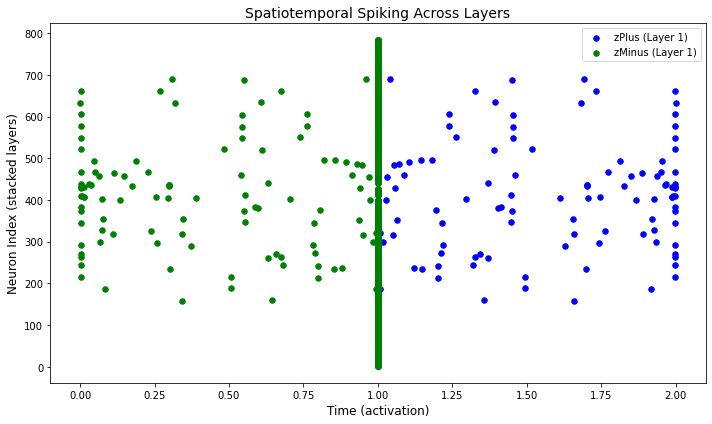

In [56]:
import matplotlib.pyplot as plt
import numpy as np

#input spk time layer STP
# Assume zPlus1/zMinus1: layer 1, zPlus2/zMinus2: layer 2
Xpp = Xp.squeeze().detach().cpu().numpy()
Xnn = Xn.squeeze().detach().cpu().numpy()


n1 = len(Xpp)

# Offset y for second layer (to stack layers vertically)
y1 = np.arange(1, n1 + 1)

plt.figure(figsize=(10, 6))
plt.scatter(Xpp, y1, c='blue', label='zPlus (Layer 1)', s=30)
plt.scatter(Xnn, y1, c='green', label='zMinus (Layer 1)', s=30)
# plt.scatter(zPlus2, y2, c='blue', marker='x', label='zPlus (Layer 2)', s=30)
# plt.scatter(zMinus2, y2, c='green', marker='x', label='zMinus (Layer 2)', s=30)

plt.xlabel('Time (activation)', fontsize=12)
plt.ylabel('Neuron Index (stacked layers)', fontsize=12)
plt.title('Spatiotemporal Spiking Across Layers', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


torch.Size([1, 1568])
torch.Size([1, 784, 1])
torch.Size([784])
784


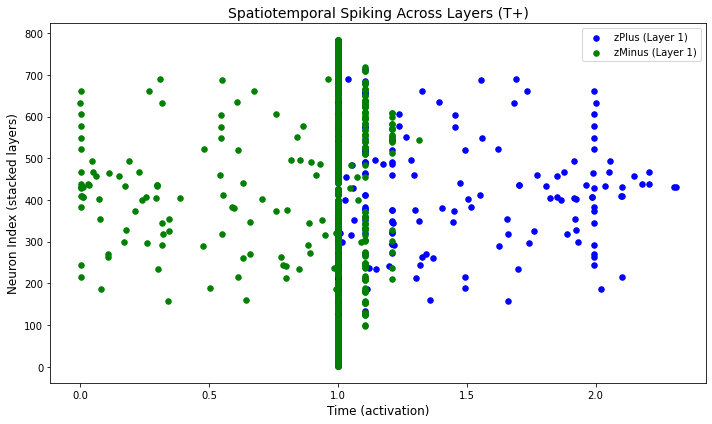

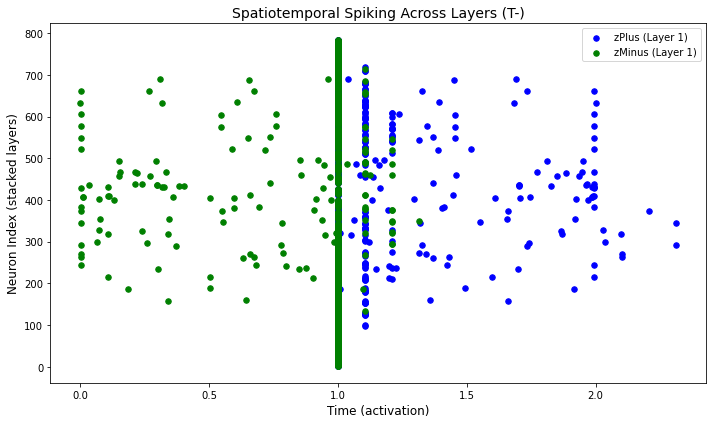

In [57]:
import matplotlib.pyplot as plt
import numpy as np

#pre-synaptic input spk time layer STP
# Assume zPlus1/zMinus1: layer 1, zPlus2/zMinus2: layer 2
kk = 1
Xpp = zPlus[:,:784,kk].squeeze().detach().cpu()
Xpp1 = zPlus[:,784:,kk].detach().cpu()
Xnn = zMinus[:,:784,kk].detach().cpu()
Xnn1 = zMinus[:,784:,kk].detach().cpu()
print(zPlus[:,:,kk].detach().cpu().size())
print(Xp.size())
print(Xpp.size())

n1 = len(Xpp)
print(n1)
# Offset y for second layer (to stack layers vertically)
y1 = np.arange(1, n1 + 1)

plt.figure(figsize=(10, 6))
plt.scatter(Xpp, y1, c='blue', label='zPlus (Layer 1)', s=30)
plt.scatter(Xpp1, y1, c='green', label='zMinus (Layer 1)', s=30)
# plt.scatter(zPlus2, y2, c='blue', marker='x', label='zPlus (Layer 2)', s=30)
# plt.scatter(zMinus2, y2, c='green', marker='x', label='zMinus (Layer 2)', s=30)

plt.xlabel('Time (activation)', fontsize=12)
plt.ylabel('Neuron Index (stacked layers)', fontsize=12)
plt.title('Spatiotemporal Spiking Across Layers (T+)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(Xnn, y1, c='blue', label='zPlus (Layer 1)', s=30)
plt.scatter(Xnn1, y1, c='green', label='zMinus (Layer 1)', s=30)
# plt.scatter(zPlus2, y2, c='blue', marker='x', label='zPlus (Layer 2)', s=30)
# plt.scatter(zMinus2, y2, c='green', marker='x', label='zMinus (Layer 2)', s=30)

plt.xlabel('Time (activation)', fontsize=12)
plt.ylabel('Neuron Index (stacked layers)', fontsize=12)
plt.title('Spatiotemporal Spiking Across Layers (T-)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


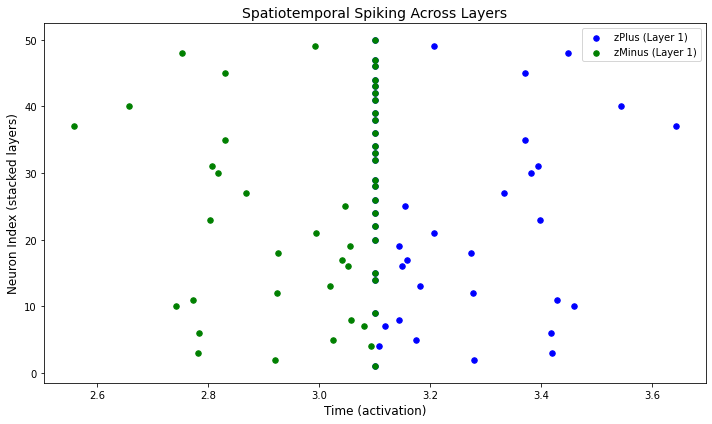

In [58]:
import matplotlib.pyplot as plt
import numpy as np

#input spk time layer STP
# Assume zPlus1/zMinus1: layer 1, zPlus2/zMinus2: layer 2
zPlus1 = th1p.squeeze().detach().cpu().numpy()
zMinus1 = th1n.squeeze().detach().cpu().numpy()


n1 = len(zPlus1)

# Offset y for second layer (to stack layers vertically)
y1 = np.arange(1, n1 + 1)

plt.figure(figsize=(10, 6))
plt.scatter(zPlus1, y1, c='blue', label='zPlus (Layer 1)', s=30)
plt.scatter(zMinus1, y1, c='green', label='zMinus (Layer 1)', s=30)
# plt.scatter(zPlus2, y2, c='blue', marker='x', label='zPlus (Layer 2)', s=30)
# plt.scatter(zMinus2, y2, c='green', marker='x', label='zMinus (Layer 2)', s=30)

plt.xlabel('Time (activation)', fontsize=12)
plt.ylabel('Neuron Index (stacked layers)', fontsize=12)
plt.title('Spatiotemporal Spiking Across Layers', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


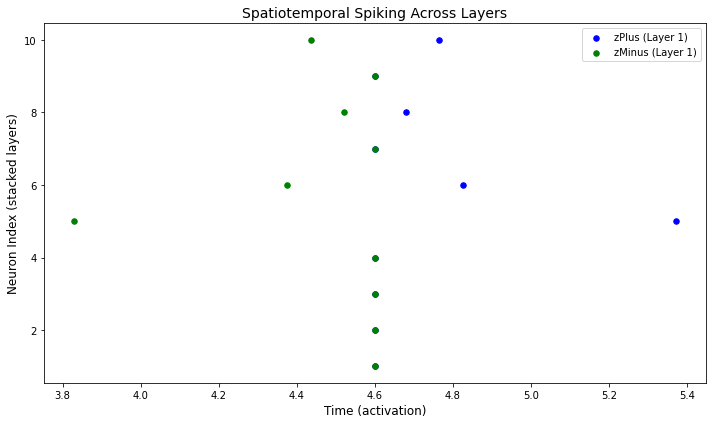

In [59]:
import matplotlib.pyplot as plt
import numpy as np

#input spk time layer STP
# Assume zPlus1/zMinus1: layer 1, zPlus2/zMinus2: layer 2
zPlus1 = th1p1.squeeze().detach().cpu().numpy()
zMinus1 = th1n1.squeeze().detach().cpu().numpy()
n1 = len(zPlus1)

# Offset y for second layer (to stack layers vertically)
y1 = np.arange(1, n1 + 1)

plt.figure(figsize=(10, 6))
plt.scatter(zPlus1, y1, c='blue', label='zPlus (Layer 1)', s=30)
plt.scatter(zMinus1, y1, c='green', label='zMinus (Layer 1)', s=30)
# plt.scatter(zPlus2, y2, c='blue', marker='x', label='zPlus (Layer 2)', s=30)
# plt.scatter(zMinus2, y2, c='green', marker='x', label='zMinus (Layer 2)', s=30)

plt.xlabel('Time (activation)', fontsize=12)
plt.ylabel('Neuron Index (stacked layers)', fontsize=12)
plt.title('Spatiotemporal Spiking Across Layers', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
print(th1p.size())
th = torch.cat([(th1p),(th1n)],axis=1)
print(th)
# print(indn1[:,:,0])
print(indn1[:,:,1])
# print(indn1[:,:,2])
# print(indn1[:,:,3])
print(indn1[:,:,4])
# print(indn1[:,:,5])
# print(indn1[:,:,6])
# print(indn1[:,:,7])
# print(indn1[:,:,8])
# print(indn1[:,:,9])

inn1 = (th[:,indn1[:,:,1]])
print(inn1)
inn4 = (th[:,indn1[:,:,4]])
print(inn4)

# Count common terms in each unique pair
n = 10
print("Common elements between each pair:")
for i in range(n):
    for j in range(i+1, n):
        common = torch.isin(indn1[:,:,i].flatten(),indn1[:,:,j].flatten())
        common_elements_raw = indn1[:,:,i].flatten()[common]
        print(common_elements_raw," common elements")

torch.Size([1, 50])
tensor([[3.1000, 3.2793, 3.4187, 3.1071, 3.1748, 3.4169, 3.1185, 3.1431, 3.1000,
         3.4582, 3.4274, 3.2767, 3.1809, 3.1000, 3.1000, 3.1484, 3.1583, 3.2740,
         3.1444, 3.1000, 3.2066, 3.1000, 3.3978, 3.1000, 3.1540, 3.1000, 3.3322,
         3.1000, 3.1000, 3.3816, 3.3939, 3.1000, 3.1000, 3.1000, 3.3703, 3.1000,
         3.6418, 3.1000, 3.1000, 3.5429, 3.1000, 3.1000, 3.1000, 3.1000, 3.3707,
         3.1000, 3.1000, 3.4478, 3.2075, 3.1000, 3.1000, 2.9207, 2.7813, 3.0929,
         3.0252, 2.7831, 3.0815, 3.0569, 3.1000, 2.7418, 2.7726, 2.9233, 3.0191,
         3.1000, 3.1000, 3.0516, 3.0417, 2.9260, 3.0556, 3.1000, 2.9934, 3.1000,
         2.8022, 3.1000, 3.0460, 3.1000, 2.8678, 3.1000, 3.1000, 2.8184, 2.8061,
         3.1000, 3.1000, 3.1000, 2.8297, 3.1000, 2.5582, 3.1000, 3.1000, 2.6571,
         3.1000, 3.1000, 3.1000, 3.1000, 2.8293, 3.1000, 3.1000, 2.7522, 2.9925,
         3.1000]], device='cuda:0')
tensor([[52, 55, 59, 62, 65, 67, 72, 74, 76, 79, 80, 

In [61]:
print(quant_k2.size())
kk = quant_k2.clone()
wt = (kk[:,1])
wp = F.relu(wt)
wn = F.relu(-wt)
ww = torch.cat([wn,wp])
wts1 = (ww[indn1[:,:,1]])
print((torch.mean(wts1 + inn1)))
print((wts1 + inn1))

wt = (kk[:,4])
wp = F.relu(wt)
wn = F.relu(-wt)
ww = torch.cat([wn,wp])
wts4 = (ww[indn1[:,:,4]])
print((torch.mean(wts4 + inn4)))
print(wts4 + inn4)

torch.Size([50, 10])
tensor(2.8308, device='cuda:0')
tensor([[[2.7813, 2.7831, 2.7418, 3.0191, 3.0516, 2.9260, 2.8101, 3.0460,
          2.8678, 2.8184, 2.8061, 2.5582, 2.6571, 2.8293, 2.7522, 2.8455]]],
       device='cuda:0')
tensor(2.8926, device='cuda:0')
tensor([[[2.9285, 3.0252, 2.7497, 2.7883, 2.9233, 3.0191, 3.0516, 3.0417,
          2.8180, 3.0460, 2.8184, 2.8218, 2.8455, 2.5817, 2.7679, 3.0556]]],
       device='cuda:0')


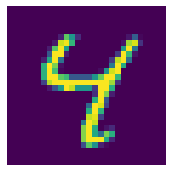

In [62]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# De-normalize if needed (example values for CIFAR10)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Select image
i = 6 #class1 - 14,5 class4 - 19,6
img_tensor = images[i]  # shape: [3, 32, 32]

# De-normalize
for c in range(1):
    img_tensor[c] = img_tensor[c] * std[c] + mean[c]

# Convert to numpy and transpose to [H, W, C] for plotting
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

# Plot
plt.figure(figsize=(2.5, 2.5))
plt.imshow(img_np)

plt.axis('off')
plt.tight_layout()
plt.show()
